In [1]:
import awkward1 as ak
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
import numpy as np
from tqdm import tqdm,trange
import matplotlib.pyplot as plt

In [2]:
infile="data/data/F61C1E0B-F61C-B044-9B45-A711DABCFB75_skim_2ElIdPt20.root"

#infile="data/mc/59AB328B-F0E3-F544-98BB-E5E55577C649_skim_2ElIdPt20.root"
#infile='data/data/7B56E217-555E-1C41-9494-491849A9835F_skim_2ElIdPt20.root'

In [3]:
events = NanoEventsFactory.from_root(infile, schemaclass=NanoAODSchema).events()

In [5]:
# Trigger set

year='2018'

doubleelectron_triggers  ={
    '2018': [
            "Ele23_Ele12_CaloIdL_TrackIdL_IsoVL", # Recomended
            ]
}



singleelectron_triggers = { #2017 and 2018 from monojet, applying dedicated trigger weights
        '2016': [
            'Ele27_WPTight_Gsf',
            'Ele105_CaloIdVT_GsfTrkIdT'
        ],
        '2017': [
            'Ele35_WPTight_Gsf',
            'Ele115_CaloIdVT_GsfTrkIdT',
            'Photon200'
        ],
        '2018': [
            'Ele32_WPTight_Gsf',   # Recomended
        ]
}

def flat_dim(arr):

    sub_arr = ak.flatten(arr)
    mask = ~ak.is_none(sub_arr)

    return ak.to_numpy(sub_arr[mask])

In [6]:
# double lepton trigger
is_double_ele_trigger=True
if not is_double_ele_trigger:
    double_ele_triggers_arr=np.ones(len(events), dtype=np.bool)
else:
    double_ele_triggers_arr = np.zeros(len(events), dtype=np.bool)
    for path in doubleelectron_triggers[year]:
        if path not in events.HLT.fields: continue
        double_ele_triggers_arr = double_ele_triggers_arr | events.HLT[path]


# single lepton trigger
is_single_ele_trigger=True
if not is_single_ele_trigger:
    single_ele_triggers_arr=np.ones(len(events), dtype=np.bool)
else:
    single_ele_triggers_arr = np.zeros(len(events), dtype=np.bool)
    for path in singleelectron_triggers[year]:
        if path not in events.HLT.fields: continue
        single_ele_triggers_arr = single_ele_triggers_arr | events.HLT[path]

In [7]:
Initial_events = events
print("#### Initial events: ",len(Initial_events))
#events = events[single_ele_triggers_arr | double_ele_triggers_arr]
events = events[double_ele_triggers_arr]

#### Initial events:  28366


---
### Event and Particle selection

In [8]:
Electron = events.Electron
Photon   = events.Photon
Jet      = events.Jet

In [9]:
mask1 = (1 << 1) | (1 << 3) | (1 << 5) | (1 << 7) | (1 << 9) | (1 << 11) | (1 << 13) # All cut are applied
mask5 = (1 << 1) | (1 << 3) | (1 << 5) | (1 << 9) | (1 << 11) | (1 << 13) # Medium photon ID without sieie


def Particle_selection(ele,pho):
    # --Electron selection-- #
    EleSelmask = (ele.pt > 25) & (np.abs(ele.eta) < 2.5) & (ele.cutBased > 2)

    # --Photon selection-- #
    
    # Cut ID bit
    #PhoSelmask = (pho.pt > 25) & (pho.cutBased > 1)
    
    #> VID Binary bitmap to separate all cuts in cut ID
    #> | pt | scEta | H over EM | sigma ieie | Isochg | IsoNeu | Isopho |
    #> | 10 | 10 | 10 | 10 | 10 | 10 | 10 |

    #> 00 -> Fail
    #> 01 -> Loose
    #> 10 -> Medium
    #> 11 -> Tight
    
    bitmap = pho.vidNestedWPBitmap & mask1
    PhoSelmask = (pho.pt > 25) & (bitmap == mask5)
    return EleSelmask,PhoSelmask

In [10]:
# Event Selection
Electron_mask, Photon_mask  = Particle_selection(Electron,Photon)
Ele_channel_mask = ak.num(Electron[Electron_mask]) > 1
Pho_channel_mask = ak.num(Photon[Photon_mask]) > 0

Ele_channel_events = events[Ele_channel_mask & Pho_channel_mask]

eePhoton   = Ele_channel_events.Photon
eeElectron = Ele_channel_events.Electron

Ele_mask, Pho_mask = Particle_selection(eeElectron,eePhoton)
Ele_sel = eeElectron[Ele_mask]
Pho_sel = eePhoton[Pho_mask]

In [11]:
eePhoton   = Ele_channel_events.Photon
eeElectron = Ele_channel_events.Electron

Ele_mask, Pho_mask = Particle_selection(eeElectron,eePhoton)
Ele_sel = eeElectron[Ele_mask]
Pho_sel = eePhoton[Pho_mask]

In [13]:
leading_photon = make_leading_pair(Pho_sel,Ele_sel)

In [14]:
phoEE = leading_photon[leading_photon.isScEtaEE]
phoEB = leading_photon[leading_photon.isScEtaEB]

In [15]:
def make_hist(phoEE,phoEB):
    fig,axs = plt.subplots(2,3,figsize=(14,8))
    
    axs[0,0].hist(flat_dim(phoEB.hoe),bins=50,color='darkorange')
    axs[0,0].set_yscale('log')
    axs[0,0].set_title('EB hoe')
    axs[0,1].hist(flat_dim(phoEB.sieie),bins=50,color='darkorange')
    axs[0,1].set_yscale('log')
    axs[0,1].set_title('EB sieie')
    axs[0,2].hist(flat_dim(phoEB.pfRelIso03_chg),bins=50,color='darkorange')
    axs[0,2].set_yscale('log')
    axs[0,2].set_title('EB IsoChg')
    
    axs[1,0].hist(flat_dim(phoEE.hoe),bins=50)
    axs[1,0].set_yscale('log')
    axs[1,0].set_title('EE hoe')
    axs[1,1].hist(flat_dim(phoEE.sieie),bins=50)
    axs[1,1].set_yscale('log')
    axs[1,1].set_title('EE sieie')
    axs[1,2].hist(flat_dim(phoEE.pfRelIso03_chg),bins=50)
    axs[1,2].set_yscale('log')
    axs[1,2].set_title('EE IsoChg')

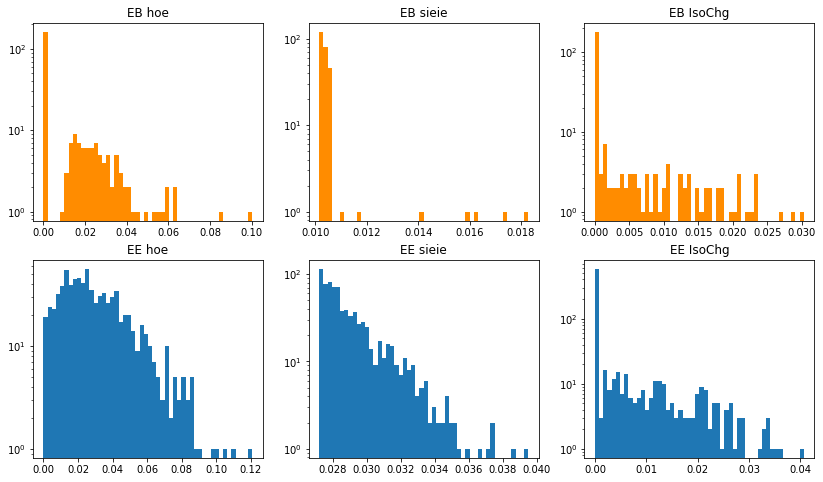

In [16]:
make_hist(phoEE,phoEB)